In [8]:
import os
import re
import pandas as pd
import numpy as np
from subprocess import Popen, PIPE
from multiprocessing import Pool
from matplotlib import pyplot as plt
import statsmodels.stats.multitest as multitest

In [9]:
# override IPython's default %%bash to not buffer all output
from IPython.core.magic import register_cell_magic
@register_cell_magic
def bash(line, cell): get_ipython().system(cell)

## Read data and sample labels

In [10]:
metadata=pd.read_csv("/home/taumata/COV_AdaptiveBiotech/AB_prediction/adaptive-metadata-edited.tsv",sep="\t")
metadata["sample_short_name"]=metadata["sample_name"].apply(lambda x: x[:-5]) #remove _TCRB from end of names
metadata["COVID-19-status"].value_counts()


acute        1140
recovered     239
baseline       74
exposed        26
non-acute       4
Name: COVID-19-status, dtype: int64

In [11]:
pd.crosstab(metadata["COVID-19-status"], metadata["diseases"], dropna=False)


diseases,covid--positive,covid--positive;adenocarcinoma--positive,covid--positive;brain-cancer--positive,covid--positive;breast-cancer--positive;hypertension--positive,covid--positive;breast-cancer--positive;t2d--positive;hypertension--positive;ckd--positive,covid--positive;ckd--positive;copd--positive,covid--positive;cll--positive,covid--positive;cll--positive;heart_failure--positive;copd--positive;coronary_artery_disease--positive,covid--positive;colon-cancer--positive;copd--positive,covid--positive;heart_failure--positive,...,covid--positive;renal-cancer--positive,covid--positive;t1d--positive,covid--positive;t1d--positive;hypertension--positive;ckd--positive;coronary_artery_disease--positive,covid--positive;t2d--positive,covid--positive;t2d--positive;ckd--positive;coronary_artery_disease--positive,covid--positive;t2d--positive;hypertension--positive,covid--positive;t2d--positive;hypertension--positive;copd--positive,covid--positive;t2d--positive;hypertension--positive;heart_failure--positive;coronary_artery_disease--positive,covid--positive;thyroid-cancer--positive,covid--positive;uterine-cancer--positive;hypertension--positive
COVID-19-status,,,,,,,,,,,,,,,,,,,,,
acute,818,1,1,1,1,1,1,1,1,1,...,0,1,1,2,0,8,0,1,1,1
baseline,31,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,8,1,0,1,1
recovered,159,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0


In [12]:
adaptive_acute=set(metadata.loc[metadata["COVID-19-status"]=="acute","sample_short_name"])

In [13]:
adaptive_recovered=set(metadata.loc[metadata["COVID-19-status"]=="recovered","sample_short_name"])

In [15]:
AB_data=pd.read_csv("/home/taumata/COV_AdaptiveBiotech/AB_prediction/AB_freq_of_top1000_leven1_v2.tsv",
                    sep="\t")

HIP_data=pd.read_csv("/home/taumata/COV_AdaptiveBiotech/AB_prediction/HIP_freq_of_top1000_leven1_v2.tsv",
                    sep="\t")

In [16]:
#select samples with status acute from Adaptive
#and take all HIP samples as healthy
AB_data_acute=AB_data.loc[set(AB_data.index.values)&adaptive_acute]

AB_data_acute["status"]="acute"
HIP_data["status"]="healthy"

print(len(AB_data_acute))
print(len(HIP_data))

1136
786


In [17]:
#combine data to one data_frame
AB_acute_and_HIP_data = pd.concat([AB_data_acute,HIP_data])

In [18]:
#extract from data dependent and independent variables
X=AB_acute_and_HIP_data[AB_acute_and_HIP_data.columns[~AB_acute_and_HIP_data.columns.isin(["status"])]]
y=AB_acute_and_HIP_data["status"]

### Random Forest on Adaptive vs HIP
using top 1000 clonotypes from Adaptive and frequencies of clonotypes

In [26]:
#HEAVILY BASED ON https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

# configure the cross-validation procedure
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# enumerate splits
outer_results = list()
class_weight = dict({"acute":786, "healthy":1140}) #weights reverse to sample sizes

for train_ix, test_ix in cv_outer.split(X,y):
    # split data
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = [y[i] for i in train_ix],[y[i] for i in test_ix]
    # configure the cross-validation procedure
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier(random_state=1,
                                   class_weight=class_weight,
                                   n_estimators=500,
                                   n_jobs=25)
    # define search space
    space = dict()
    space['max_features'] = [10, 20, 40]
    space['max_depth']=[5,9,13]
    # define search
    search = GridSearchCV(model, space, scoring='balanced_accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = balanced_accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    # output confusion matrix
    conf_mat = confusion_matrix(y_test, yhat)
    print(conf_mat)
# summarize the estimated performance of the model
print('Balanced accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>acc=0.920, est=0.926, cfg={'max_depth': 5, 'max_features': 40}
[[222   6]
 [ 21 136]]
>acc=0.925, est=0.907, cfg={'max_depth': 5, 'max_features': 40}
[[216  11]
 [ 16 142]]
>acc=0.911, est=0.922, cfg={'max_depth': 5, 'max_features': 40}
[[211  16]
 [ 17 140]]
>acc=0.949, est=0.919, cfg={'max_depth': 5, 'max_features': 40}
[[224   3]
 [ 14 143]]
>acc=0.924, est=0.924, cfg={'max_depth': 5, 'max_features': 40}
[[217  10]
 [ 17 140]]
Balanced accuracy: 0.926 (0.013)


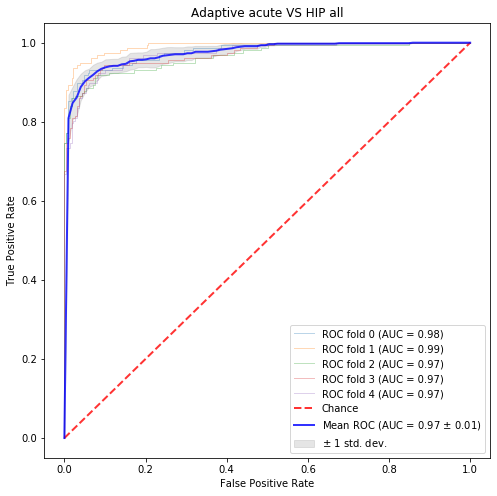

In [28]:
#MOSTLY COPIED FROM https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Classification and ROC analysis
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5,shuffle=True)

class_weight = dict({"acute":786, "healthy":1140})

clf=RandomForestClassifier(class_weight=class_weight,
                          max_depth=5, max_features=40,
                          n_estimators=500,n_jobs=25)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.rcParams["figure.figsize"] = (8,8)


fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (1,1)
for i, (train, test) in enumerate(cv.split(X, y)):
    clf.fit(X.iloc[train], [y[i] for i in train])
    viz = plot_roc_curve(clf, X.iloc[test], [y[i] for i in test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Adaptive acute VS HIP all")
ax.legend(loc="lower right")
plt.show()



### Random forest FMBA healthy vs current
using top 1000 clonotypes from Adaptive and frequencies of clonotypes

In [29]:
FMBA_data=pd.read_csv("/home/taumata/COV_AdaptiveBiotech/AB_prediction/FMBA_freq_of_top1000_leven1_v2.tsv",
                    sep="\t")


In [30]:
FMBA_metadata=pd.read_csv("/projects/fmba_covid/metadata_fmba_full.txt",sep="\t")
FMBA_metadata["sample.COVID_status"].value_counts()


healthy                472
current                410
past                   330
early                   22
undiagnosed disease     11
Name: sample.COVID_status, dtype: int64

In [31]:
fmba_healthy=set(FMBA_metadata.loc[FMBA_metadata["sample.COVID_status"]=="healthy","id"])
fmba_current=set(FMBA_metadata.loc[FMBA_metadata["sample.COVID_status"]=="current","id"])
fmba_healthy_or_current_id=fmba_healthy|fmba_current

In [32]:
FMBA_data_healthy_or_current=FMBA_data.loc[set(FMBA_data.index.values)&fmba_healthy_or_current_id]
FMBA_data_healthy_or_current["status"]="current"
FMBA_data_healthy_or_current.loc[set(FMBA_data_healthy_or_current.index.values)&fmba_healthy,"status"]="healthy"
FMBA_data_healthy_or_current["status"].value_counts()

healthy    310
current    301
Name: status, dtype: int64

In [33]:
X=FMBA_data_healthy_or_current[FMBA_data_healthy_or_current.columns[~FMBA_data_healthy_or_current.columns.isin(["status"])]]
y=list(FMBA_data_healthy_or_current["status"])


In [34]:
#HEAVILY BASED ON https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, random_state=1, n_informative=10, n_redundant=10)

# configure the cross-validation procedure
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
class_weight = dict({"current":310, "healthy":301}) #weights reverse to sample sizes

for train_ix, test_ix in cv_outer.split(X,y):
    # split data
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = [y[i] for i in train_ix],[y[i] for i in test_ix]
    # configure the cross-validation procedure
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier(random_state=1,
                                   class_weight=class_weight,
                                   n_estimators=500,
                                   n_jobs=25)
    # define search space
    space = dict()
    space['max_features'] = [10, 20, 40]
    space['max_depth']=[5,9,13]

    # define search
    search = GridSearchCV(model, space, scoring='balanced_accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = balanced_accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    conf_mat = confusion_matrix(y_test, yhat)
    print(conf_mat)
# summarize the estimated performance of the model
print('Balanced accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>acc=0.708, est=0.732, cfg={'max_depth': 5, 'max_features': 20}
[[46 15]
 [21 41]]
>acc=0.763, est=0.707, cfg={'max_depth': 9, 'max_features': 20}
[[49 11]
 [18 44]]
>acc=0.700, est=0.722, cfg={'max_depth': 9, 'max_features': 20}
[[53  7]
 [30 32]]
>acc=0.721, est=0.717, cfg={'max_depth': 13, 'max_features': 40}
[[43 17]
 [17 45]]
>acc=0.723, est=0.710, cfg={'max_depth': 13, 'max_features': 40}
[[48 12]
 [22 40]]
Balanced accuracy: 0.723 (0.022)


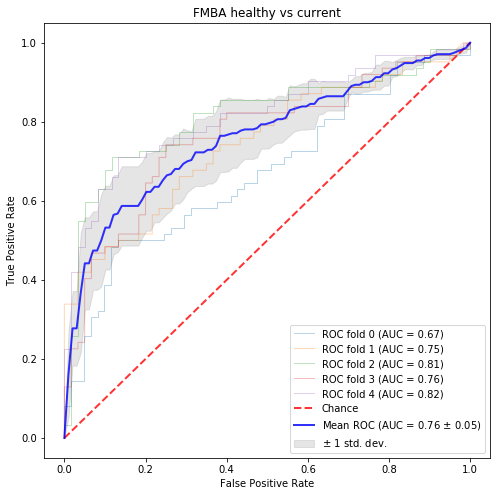

In [36]:
#MOSTLY COPIED FROM https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Classification and ROC analysis
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5,shuffle=True)

class_weight = dict({"current":310, "healthy":301})

clf=RandomForestClassifier(class_weight=class_weight,n_estimators=500,
                                       n_jobs=25,
                          max_depth=5, max_features=20)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.rcParams["figure.figsize"] = (8,8)


fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (1,1)
for i, (train, test) in enumerate(cv.split(X, y)):
    clf.fit(X.iloc[train], [y[i] for i in train])
    viz = plot_roc_curve(clf, X.iloc[test], [y[i] for i in test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="FMBA healthy vs current")
ax.legend(loc="lower right")
plt.show()




### Try to apply Random Forest trained on adaptive to FMBA
based on clonotypes absense/presence (because frequencies do nor work well in this case)

In [43]:
X=AB_acute_and_HIP_data[AB_acute_and_HIP_data.columns[~AB_acute_and_HIP_data.columns.isin(["status"])]]
y=AB_acute_and_HIP_data["status"]

In [53]:
X[X != 0] = 1

/home/taumata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
#HEAVILY BASED ON https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

# configure the cross-validation procedure
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# enumerate splits
outer_results = list()
class_weight = dict({"acute":786, "healthy":1140}) #weights reverse to sample sizes

for train_ix, test_ix in cv_outer.split(X,y):
    # split data
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = [y[i] for i in train_ix],[y[i] for i in test_ix]
    # configure the cross-validation procedure
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier(random_state=1,
                                   class_weight=class_weight,
                                   n_estimators=500,
                                   n_jobs=25)
    # define search space
    space = dict()
    space['max_features'] = [10, 20, 40]
    space['max_depth']=[5,9,13]
    # define search
    search = GridSearchCV(model, space, scoring='balanced_accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = balanced_accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    # output confusion matrix
    conf_mat = confusion_matrix(y_test, yhat)
    print(conf_mat)
# summarize the estimated performance of the model
print('Balanced accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>acc=0.808, est=0.812, cfg={'max_depth': 13, 'max_features': 20}
[[194  34]
 [ 37 120]]
>acc=0.821, est=0.810, cfg={'max_depth': 9, 'max_features': 40}
[[173  54]
 [ 19 139]]
>acc=0.798, est=0.819, cfg={'max_depth': 9, 'max_features': 20}
[[176  51]
 [ 28 129]]
>acc=0.793, est=0.814, cfg={'max_depth': 9, 'max_features': 20}
[[175  52]
 [ 29 128]]
>acc=0.836, est=0.811, cfg={'max_depth': 9, 'max_features': 20}
[[180  47]
 [ 19 138]]
Balanced accuracy: 0.811 (0.016)


In [61]:
#train model on all adaptive samples
adaptive_absence=RandomForestClassifier(class_weight=class_weight,n_estimators=500,
                                       n_jobs=25,
                                          max_depth=9, max_features=20)


adaptive_absence.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={'acute': 786, 'healthy': 1140},
                       criterion='gini', max_depth=9, max_features=20,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=25, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
#apply this model to FMBA

In [71]:
X_fmba=FMBA_data_healthy_or_current[FMBA_data_healthy_or_current.columns[~FMBA_data_healthy_or_current.columns.isin(["status"])]]
y_fmba=list(FMBA_data_healthy_or_current["status"])


In [76]:
#turn to absence/presence
X_fmba[X_fmba!=0]=1

/home/taumata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/taumata/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [72]:
#change label to becomme like adaptive
y_fmba = ["acute" if y_t =="current"  else y_t for y_t in y_fmba]

In [78]:
y_fmba_predicted=adaptive_absence.predict(X_fmba)
acc = balanced_accuracy_score(y_fmba, y_fmba_predicted)
print(acc)
conf_mat = confusion_matrix(y_fmba, y_fmba_predicted)
print(conf_mat)

0.5
[[301   0]
 [310   0]]
